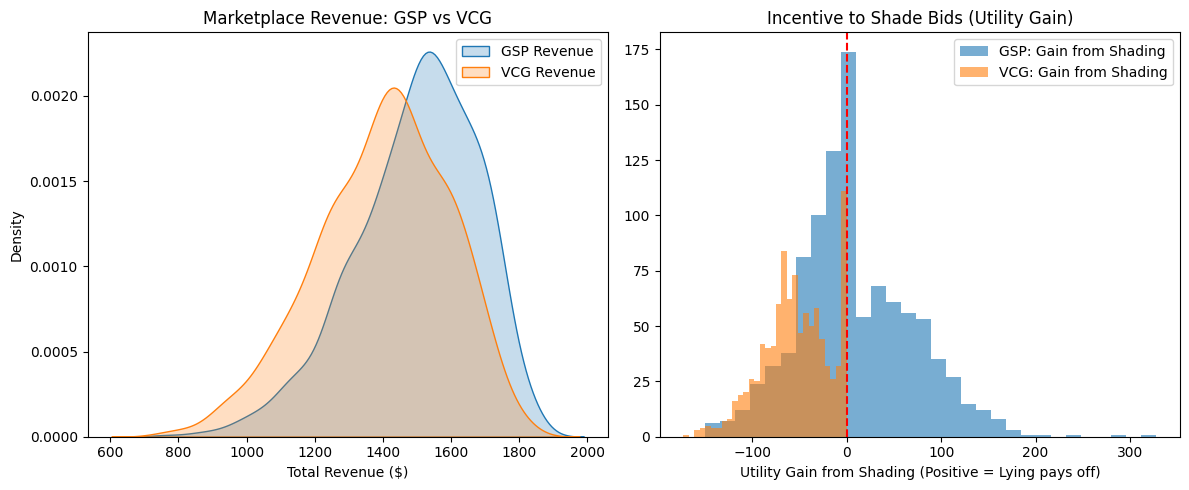

Avg GSP Revenue: $1497.53
Avg VCG Revenue: $1397.55
Freq where Shading helps in GSP: 42.3%
Freq where Shading helps in VCG: 0.0%


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 1. AUCTION CONFIGURATION
# ==========================================
class AdAuction:
    def __init__(self, num_slots=3, slot_ctrs=[1.0, 0.6, 0.3]):
        """
        num_slots: Number of ad positions available
        slot_ctrs: Click-Through-Rates (quality) of each slot.
                   Slot 1 is better than Slot 2, etc.
        """
        self.num_slots = num_slots
        self.slot_ctrs = np.array(slot_ctrs)

    def generate_bidders(self, num_bidders=10):
        """Generates bidders with random Private Valuations (True Value per Click)"""
        # Valuations drawn from a Uniform Distribution [0, 10]
        valuations = np.random.uniform(1, 10, num_bidders)
        return valuations

# ==========================================
# 2. MECHANISM 1: GSP (Generalized Second Price)
# ==========================================
# Used by Google, Pinterest, Meta.
# Rule: You pay the bid of the person directly below you.

def run_gsp_auction(bids, slot_ctrs):
    # Sort bids descending (Highest bid wins top slot)
    sorted_indices = np.argsort(bids)[::-1]
    sorted_bids = bids[sorted_indices]

    payments = np.zeros(len(bids))
    total_revenue = 0
    allocations = {} # Who got what slot

    # Assign Slots
    for i in range(len(slot_ctrs)):
        if i >= len(bids): break

        bidder_idx = sorted_indices[i]
        ctr = slot_ctrs[i]

        # GSP Payment Rule: Pay the bid of the *next* highest bidder
        # If you are the last winner, you pay the first loser's bid (or 0)
        next_bid = sorted_bids[i+1] if (i+1) < len(bids) else 0

        payment = next_bid * ctr # Payment is per-impression (simplified)
        payments[bidder_idx] = payment
        total_revenue += payment
        allocations[bidder_idx] = {'slot': i, 'ctr': ctr, 'payment': payment}

    return allocations, total_revenue

# ==========================================
# 3. MECHANISM 2: VCG (Vickrey-Clarke-Groves)
# ==========================================
# The "Truthful" Auction.
# Rule: You pay the "externality" (harm) you cause to others.

def run_vcg_auction(bids, slot_ctrs):
    sorted_indices = np.argsort(bids)[::-1]
    sorted_bids = bids[sorted_indices]

    payments = np.zeros(len(bids))
    total_revenue = 0
    allocations = {}

    for i in range(len(slot_ctrs)):
        if i >= len(bids): break
        bidder_idx = sorted_indices[i]
        ctr = slot_ctrs[i]

        # VCG Payment Logic:
        # Sum of difference in value for others if I WASN'T there vs IF I AM there.
        # Simple recursive calculation for Position Auctions:
        # P_i = (B_{i+1} * (CTR_i - CTR_{i+1})) + P_{i+1}

        payment_per_click = 0
        for j in range(i, len(slot_ctrs)):
            next_bid = sorted_bids[j+1] if (j+1) < len(bids) else 0
            current_ctr = slot_ctrs[j]
            next_ctr = slot_ctrs[j+1] if (j+1) < len(slot_ctrs) else 0

            term = next_bid * (current_ctr - next_ctr)
            payment_per_click += term

        total_payment = payment_per_click # Total expected payment
        payments[bidder_idx] = total_payment
        total_revenue += total_payment
        allocations[bidder_idx] = {'slot': i, 'ctr': ctr, 'payment': total_payment}

    return allocations, total_revenue

# ==========================================
# 4. SIMULATION LOOP (Incentive Compatibility)
# ==========================================
# Let's see what happens if bidders LIE (Shade their bids).
# In GSP, shading is often optimal. In VCG, truth is optimal.

auction = AdAuction(num_slots=3, slot_ctrs=[100, 60, 30]) # Slots with 100, 60, 30 clicks
num_simulations = 1000
results = []

for _ in range(num_simulations):
    # 1. Generate True Values
    true_values = auction.generate_bidders(num_bidders=10)

    # 2. Scenario A: Truthful Bidding (Bid = Value)
    alloc_gsp, rev_gsp = run_gsp_auction(true_values, auction.slot_ctrs)
    alloc_vcg, rev_vcg = run_vcg_auction(true_values, auction.slot_ctrs)

    # 3. Scenario B: Strategic Shading (Bid = 0.8 * Value)
    # Let's see if Shading helps the high-value bidder save money in GSP
    shaded_bids = true_values.copy()
    top_bidder_idx = np.argmax(true_values)
    shaded_bids[top_bidder_idx] = true_values[top_bidder_idx] * 0.8 # Top guy shades 20%

    alloc_gsp_shade, _ = run_gsp_auction(shaded_bids, auction.slot_ctrs)
    alloc_vcg_shade, _ = run_vcg_auction(shaded_bids, auction.slot_ctrs)

    # Calculate Utility for the Top Bidder
    # Utility = (True Value * CTR) - Payment

    # GSP Utility (Truth vs Shaded)
    def get_util(alloc, idx, val):
        if idx in alloc:
            return (val * alloc[idx]['ctr']) - alloc[idx]['payment']
        return 0

    util_gsp_truth = get_util(alloc_gsp, top_bidder_idx, true_values[top_bidder_idx])
    util_gsp_shade = get_util(alloc_gsp_shade, top_bidder_idx, true_values[top_bidder_idx])

    # VCG Utility (Truth vs Shaded)
    util_vcg_truth = get_util(alloc_vcg, top_bidder_idx, true_values[top_bidder_idx])
    util_vcg_shade = get_util(alloc_vcg_shade, top_bidder_idx, true_values[top_bidder_idx])

    results.append({
        'revenue_gsp': rev_gsp,
        'revenue_vcg': rev_vcg,
        'gsp_gain_from_lying': util_gsp_shade - util_gsp_truth,
        'vcg_gain_from_lying': util_vcg_shade - util_vcg_truth
    })

df_res = pd.DataFrame(results)

# ==========================================
# 5. VISUALIZATION
# ==========================================

plt.figure(figsize=(12, 5))

# Plot 1: Revenue Comparison
plt.subplot(1, 2, 1)
sns.kdeplot(df_res['revenue_gsp'], label='GSP Revenue', fill=True)
sns.kdeplot(df_res['revenue_vcg'], label='VCG Revenue', fill=True)
plt.title("Marketplace Revenue: GSP vs VCG")
plt.xlabel("Total Revenue ($)")
plt.legend()

# Plot 2: Incentive to Lie
plt.subplot(1, 2, 2)

plt.hist(df_res['gsp_gain_from_lying'], alpha=0.6, label='GSP: Gain from Shading', bins=30)
plt.hist(df_res['vcg_gain_from_lying'], alpha=0.6, label='VCG: Gain from Shading', bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title("Incentive to Shade Bids (Utility Gain)")
plt.xlabel("Utility Gain from Shading (Positive = Lying pays off)")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Avg GSP Revenue: ${df_res['revenue_gsp'].mean():.2f}")
print(f"Avg VCG Revenue: ${df_res['revenue_vcg'].mean():.2f}")
print(f"Freq where Shading helps in GSP: {(df_res['gsp_gain_from_lying'] > 0).mean():.1%}")
print(f"Freq where Shading helps in VCG: {(df_res['vcg_gain_from_lying'] > 0).mean():.1%}")